### Stimulation Prediction Model
The goal of this notebook is to build binary a classification model capable of predicting whether or not a user will login back into FPC after being contacted for the survey. The model will be used to ensure only users who have a high enough probability of being stimulated will contacted, hence, increasing stimulation rates. 

Data fields:

- `Completion_Time`: hour of the day the call was made
- `Completion_Date`: date the call was made
- `Associate`: associate who made the call
- `Carrier_Email`: EUS username of the dispatcher called
- `Call_Response`: category indicating whether or not the call was accepted, denied, or not answered
- `Disengagement_Reason`: category indicating the reason for the user's disengagement
- `Suggestions`: text entry describing  the suggestions the user had for FPC
- `Reason_Elaboration`: text entry explaining the reason for the user's failure to log in
- `Transportation_Method`: category identifying user as a PO or Dry Van carrier
- `Sentiment`: positive or negative category based on the caller's interpretation of the user's feedback
- `Duration`: number of minutes it took the caller to complete the survey
- `MC`: MC number of the user's carrier
- `DOT`: DOT number of the user's carrier
- `City`: city the user's carrier is located in
- `State`: state the user's carrier is located in
- `Size`: number of trucks the carrier has
- `Login_Window`: how many days it was since the user's last login at the time they were contacted
- `Sponsored`: whether or not the user's carruer has a sponsor (1 = True)
- `Last_login`: date of the user's most recent login
- `Login_Contact_Window`: time difference between the users last login and when they were contacted in days
- `Stimulated`: whether or not a user logged back into FPC at most four days after being contacted (1 = True)
- `Size_Category`: user's carrier size categorized by industry standard size intervals
- `Size_Category`: whether or not the user too the survey or not (1 = True) 

In [59]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from datetime import datetime
import os
import seaborn as sns

# ML
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import precision_recall_curve
import statsmodels.api as sm

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [60]:
# Functions
def abline(slope, intercept):
    """Plots a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, 'r--')

def size_category(size):
    '''Transforms carrier size to a categorical varialbe based on idustry standards'''
    if size == 1:
        return 0
    elif size > 1 and size < 11:
        return 2
    elif size > 10 and size < 51:
        return 3
    elif size > 50 and size < 201:
        return 4
    else:
        return 5
def trendline_scatter(df, x, y, title='Title'):
    td = df.groupby(x).mean()[y].reset_index()
    x = td[x].astype(int)
    y = td[y]
    plt.scatter(x, y, alpha = 0.8)
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    abline(slope, intercept)
    plt.title(title)
    print(f'R-sq: {r_value**2}\nP-val: {p_value}\nError: {std_err}')

def cross_validation(model, _X, _y, cv=5):
  _scoring = ['accuracy', 'precision', 'recall', 'f1']
  results = cross_validate(estimator=model,
                           X=_X,
                           y=_y,
                           cv=cv,
                           scoring=_scoring,
                           return_train_score=True)
  
  return {
          "Mean Training Accuracy": results['train_accuracy'].mean()*100,
          "Mean Training Precision": results['train_precision'].mean(),
          "Mean Training Recall": results['train_recall'].mean(),
          "Mean Training F1 Score": results['train_f1'].mean(),
          
          "Mean Validation Accuracy": results['test_accuracy'].mean()*100,
          "Mean Validation Precision": results['test_precision'].mean(),
          "Mean Validation Recall": results['test_recall'].mean(),
          "Mean Validation F1 Score": results['test_f1'].mean()
          }

#### Data Cleaning and Preparation

In [61]:
# Dictionary for renaming columns
rename_map = {
'Carrier Email':'Carrier_Email',
'Carrier MC Number':'MC',
'Call Response':'Call_Response',
'Disengagement Reason':'Disengagement_Reason',
'Reason Elaboration':'Reason_Elaboration',
'Preferred transportation method':'Transport_Method',
"Was this user's feedback overall positive or negative? (use your best judgement - don't ask the user this)":"Sentiment",
'Duration (min)':'Duration',
'Completion Date':'Completion_Date',
'usDotNumber':'DOT','daysSinceCall':'Call_Window',
'userLastLogin':'Last_Login', 
'daysSinceLogin':'Login_Window', 
'loginContactWindow':'Login_Contact_Window',
'Stimualted':'Stimulated',
'Completion time':'Completion_Time', 
'Ref: Carrier Sponsor':'Sponsored',
'companyName':'Company',
'mcNumber':'MC'
}

In [62]:
# Data cleaning and column creation
df = pd.read_csv('full_survey_data.csv', encoding='latin-1').rename(columns=rename_map)
df = df[df.Stimulated != '.']
state_count = df.State.value_counts().to_dict()
df.dropna(subset='State', inplace=True)
df = (df #
        .assign(
                Stimulated = df.Stimulated.replace({'True':1, 'False':0}), 
                Size_Category = df.Size.apply(size_category), 
                Call_Category = df.Call_Response.apply(lambda x:1 if x == 'Accept' else 0),
                Completion_Date = df.Completion_Date.apply(lambda x:datetime.strptime(x,'%Y-%m-%d' )),
                Completion_Time = df.Completion_Time.apply(lambda x:x.split(' ')[1].split(':')[0]),
                Sponsored = df.Sponsored.apply(lambda x: 1 if pd.notnull(x) else 0), 
                State = df.State.apply(lambda x:x if state_count[x] > 10 else 'Other')
                )
        .drop(columns=['MC', 'Name'])
        )

for col in df.select_dtypes(include=np.number).columns.tolist(): # filling all NA values to 0 for numerical columns
        df[col] = df[col].fillna(0).astype(int)

In [63]:
# Counting null values per field
for col in df.columns:
    print(f'{col}: ', df[col].isna().sum())

ID:  0
Completion_Time:  0
Associate:  0
Carrier_Email:  0
Call_Response:  0
Disengagement_Reason:  2401
Reason_Elaboration:  2996
Transport_Method:  3194
Suggestions:  4005
Sentiment:  3962
Duration:  0
Completion_Date:  0
DOT:  0
City:  0
State:  0
Size:  0
Login_Window:  0
Sponsored:  0
Last_Login:  0
Call_Window:  0
Login_Contact_Window:  0
Stimulated:  0
Size_Category:  0
Call_Category:  0


All new features added, all fields modified, and the data appears to be clean. Columns that have NA values are expected to have missing content due due to their call category.

#### EDA

Analyze and investigate the data to summarize the information, find important trends, and test hypotheses. Questions to answer:
- What are some basic inferences drawn from the summary statistics?
- What known factors have an effect on stimulation rates?

Summary

In [79]:
print(f'Number of users contacted: {len(df)}')
print(f'Overall stimulation rate: {round(df.Stimulated.mean(),2)}')
print(f"Avg. number of days since the user's last login when contacted: {round(df.Login_Window.mean(),2)}")
print(f"Proportion of sponsored carriers: {round(df.Sponsored.mean(),2)}")
print(f'Average carrier size: {round(df.Size.mean())} trucks')

Number of users contacted: 5042
Overall stimulation rate: 0.24
Avg. number of days since the user's last login when contacted: 34.07
Proportion of sponsored carriers: 0.04
Average carrier size: 46 trucks


Features

R-sq: 0.6506172103956931
P-val: 2.904140835813142e-22
Error: 0.00024001508737222176


Text(0.5, 1.0, 'Stimulation vs Sponsorship')

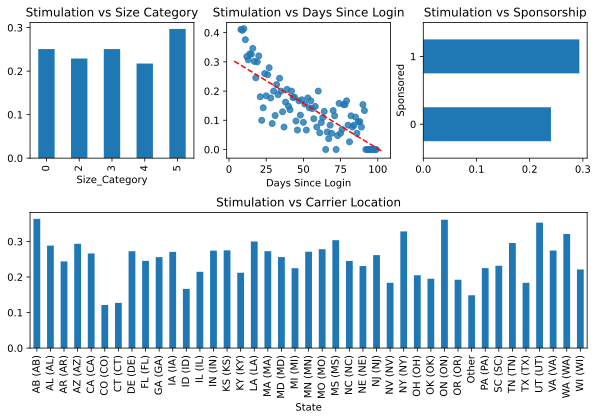

In [66]:
fig = plt.figure(figsize=(10,6), dpi=1600)

plt.subplots_adjust(hspace=0.4)

ax1 = plt.subplot2grid((2,3),(0,0))
df.groupby('Size_Category').mean().Stimulated.plot(kind='bar')
plt.title('Stimulation vs Size Category')

ax2 = plt.subplot2grid((2,3),(0,1))
trendline_scatter(df, 'Login_Window', 'Stimulated', 'Stimulation vs Days Since Login' )
plt.xlabel('Days Since Login')

ax3 = plt.subplot2grid((2,3),(1,0), colspan=3)
# df['State'] = df.State.apply(lambda x: 'Other' if len(df[df.State == x]) < 20 else x)
df.groupby('State').mean().Stimulated.plot(kind='bar')
plt.title('Stimulation vs Carrier Location')

ax4 = plt.subplot2grid((2,3),(0,2), colspan=1)
df.groupby('Sponsored').mean().Stimulated.plot(kind='barh')
plt.title('Stimulation vs Sponsorship')

- Size Category: within each size category there seems to be a fair bit of stimulation variation, especially in comparison to size category 5 
- Days Since Login: The scatterplot shows a very clear negative linear relationship between days since login and stimulation
- Sponsorship: There seems to be a reasonable increase in stimulation for users that are sponsored by the company
- State: There is clearly substantial stimulation variation between different carrier locations (note that states that occured less than 10 times were categorized as "Other")

#### Model Building

We want to create a model that is capable of predicting whether or not a user will be stimulated. The model should be able to estimate a user's probability of logging back into the application from a call, and then make its prediction based on a manually set threshold. The process will be similar to logistic regression, but without automatically setting a probability threshold. The reason for this change is to account for the value discrepancy between correctly and incorrectly classified users. The value of correctly identifying a user as being stimulated far outweighs the cost incorrectly assuming a user to be stimulated. 

In [67]:
# Dummy variables
pdf = df[['Stimulated', 'Size_Category', 'State', 'Sponsored', 'Login_Window']]
pdf = pd.get_dummies(pdf, columns=['Size_Category'], prefix = 'Size', drop_first=True)
pdf = pd.get_dummies(pdf, columns=['Sponsored'], prefix = 'Sponsored', drop_first=True)
pdf = pd.get_dummies(pdf, columns=['State'], drop_first=True)

(0.0, 1.0)

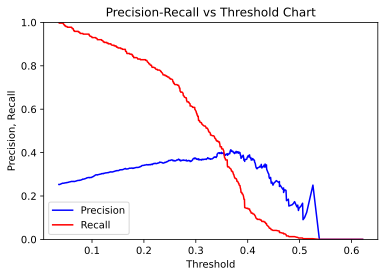

In [107]:
# Feature assignemnt
x = pdf.drop(columns=['Stimulated'])
y = pdf.Stimulated

# Data splitting, model training, and loss metric plotting
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.25,random_state=20)
log_model = LogisticRegression(max_iter=1000)
log_model.fit(x_train,y_train)

probs = log_model.predict_proba(x_test) 
precision, recall, thresholds = precision_recall_curve(y_test, probs[:, 1]) # Probability of being stimulated ([:1] of probs_y)
pr_auc = metrics.auc(recall, precision)

plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "b", label="Precision")
plt.plot(thresholds, recall[: -1], "r", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])

- Precision: if the model predicted that 100 users would be stimulated, and in reality, 40 of those predicted users were actually stimulated, the model precision would be 40%
- Recall: if in reality 100 users would have been stimulated by being called, and the model only told us that 47 of those users would be stimulated, the model recall would be 47%.

In [108]:
# Threshold sensitve scores
preds = (pd.DataFrame(probs)[1].apply(lambda x: 1 if x > 0.35 else 0)).array
print("Accuracy:",metrics.accuracy_score(y_test, preds))
print("Precision:",metrics.precision_score(y_test, preds, pos_label=1))
print("Recall:",metrics.recall_score(y_test, preds, pos_label=1))

Accuracy: 0.697065820777161
Precision: 0.396969696969697
Recall: 0.4171974522292994


At a probability threshold of 0.35, the model is able to correctly identify a user as stimulated 40% of the time while still capturing a good proportion of all users that would have been stimulated by a call (42%). Using this model to determine what users should be called for the survey would likely <b> increase the overall survey stimulation rate from 24% to 40% </b>. 